In [1]:
import sys
import os

if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

In [2]:
import numpy as np

import functools
import itertools
import toolz

from emtf_algos import *
from emtf_logger import get_logger
from emtf_colormap import get_colormap

In [3]:
# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as k_layers
from tensorflow.keras import backend as k_backend
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

#import numba
#from numba import njit, vectorize
import dask
import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
#logger.info('Using numba      : {0}'.format(numba.__version__))
logger.info('Using dask       : {0}'.format(dask.__version__))

assert k_backend.backend() == 'tensorflow'
assert k_backend.image_data_format() == 'channels_last'

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.19.2
[INFO    ] Using tensorflow : 2.4.0
[INFO    ] Using keras      : 2.4.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using matplotlib : 3.3.2
[INFO    ] Using dask       : 2020.12.0


In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

# masked array filling value
ma_fill_value = 999999

#maxevents = 10
maxevents = -1

workers = 1
#workers = 8

# Input files
features_fname = 'features_zone%i.h5' % zone


# Scheduler
dask.config.set(scheduler='threads', num_workers=workers)

# Styling
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. workers          : {0}'.format(workers))

[INFO    ] Processing zone 0 timezone 0
[INFO    ] .. maxevents        : -1
[INFO    ] .. workers          : 1


### Load data

In [5]:
import h5py
file_handles = []

def load_features():
  features = []
  truths = []
  for i in range(num_emtf_zones):
    fname = features_fname.replace('zone%i' % zone, 'zone%i' % i)  # modify filename
    logger.info('Loading from {0}'.format(fname))
    loaded = h5py.File(fname, 'r')
    file_handles.append(loaded)
    features.append(da.from_array(loaded['features']))
    truths.append(da.from_array(loaded['truths']))
  features = da.concatenate(features, axis=0)
  truths = da.concatenate(truths, axis=0)
  features, truths = dask.compute(features, truths)
  logger.info('features: {0} (dtype={1}) truths: {2} (dtype={3})'.format(features.shape, features.dtype, truths.shape, truths.dtype))
  return features, truths

In [6]:
# Load features and truths
features, truths = load_features()

for file_handle in file_handles:  # close files
  file_handle.close()

[INFO    ] Loading from features_zone0.h5
[INFO    ] Loading from features_zone1.h5
[INFO    ] Loading from features_zone2.h5
[INFO    ] features: (1751565, 40) (dtype=int32) truths: (1751565, 9) (dtype=float32)


In [7]:
def train_test_split(*arrays, test_size=0.4, shuffle=True):
  assert(len(arrays) >= 2)
  num_samples = arrays[0].shape[0]
  num_train_samples = int(np.ceil(num_samples * (1.0 - test_size)))
  num_test_samples = num_samples - num_train_samples
  index_array = np.arange(num_samples)
  if shuffle:
    np.random.shuffle(index_array)
  index_array_train, index_array_test = index_array[:num_train_samples], index_array[num_train_samples:]

  train_test_pairs = (
      (arr[index_array_train], arr[index_array_test])
      for arr in arrays
  )
  return tuple(itertools.chain.from_iterable(train_test_pairs))

In [8]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(features, truths)

# Convert x_train, x_test to floating-point
ismasked = lambda x: x == ma_fill_value
x_train_mask = ismasked(x_train)
x_test_mask = ismasked(x_test)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train[x_train_mask] = np.nan
x_test[x_test_mask] = np.nan

# Modify parameter of interest
pt_regr_scale = 1.
y_train = y_train[:, 0:1]
y_test = y_test[:, 0:1]
y_train *= pt_regr_scale
y_test *= pt_regr_scale

logger.info('x_train: {0} y_train: {1} x_test: {2} y_test: {3}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

[INFO    ] x_train: (1050939, 40) y_train: (1050939, 1) x_test: (700626, 40) y_test: (700626, 1)


In [9]:
# Preprocessing layer
from k_preprocessing_normalization import Normalization as MyNormalization
preprocessing_layer = MyNormalization()
preprocessing_layer.adapt(x_train)

y_preprocessing_layer = MyNormalization()
y_preprocessing_layer.adapt(y_train)

In [10]:
# Debug
_ = np.nanmean(x_train, axis=0, dtype=np.float64)
assert _.shape == preprocessing_layer.mean.shape
assert np.allclose(_, preprocessing_layer.mean.numpy())
_ = np.nanvar(x_train, axis=0, dtype=np.float64)
assert _.shape == preprocessing_layer.variance.shape
assert np.allclose(_, preprocessing_layer.variance.numpy())

In [11]:
#FIXME
x_train = nan_to_num(x_train)
x_test = nan_to_num(x_test)

### Create model

In [12]:
learning_rate = 0.001
gradient_clip_norm = 1.

def create_model(nodes1=30, nodes2=20, nodes3=10, nodes_in=40, nodes_out=1):
  inputs = keras.Input(shape=(nodes_in,), name='inputs')

  # Preprocessing
  x = preprocessing_layer(inputs)

  seq = keras.Sequential([
      # Hidden layer 1
      k_layers.Dense(nodes1, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
      k_layers.BatchNormalization(epsilon=1e-4, momentum=0.9),
      k_layers.Activation('tanh'),
      # Hidden layer 2
      k_layers.Dense(nodes2, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
      k_layers.BatchNormalization(epsilon=1e-4, momentum=0.9),
      k_layers.Activation('tanh'),
      # Hidden layer 3
      k_layers.Dense(nodes3, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
      k_layers.BatchNormalization(epsilon=1e-4, momentum=0.9),
      k_layers.Activation('tanh'),
      # Output layer
      k_layers.Dense(nodes_out, kernel_initializer='zeros', use_bias=True, activation=None),
  ])
  x = seq(x)

  outputs = x

  # Model
  adam = keras.optimizers.Adam(lr=learning_rate, clipnorm=gradient_clip_norm)
  model = keras.Model(inputs=inputs, outputs=outputs, name='awesome_model')
  model.compile(optimizer=adam, loss='mse')

  # Summary
  model.summary()
  seq.summary()
  return model

model = create_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 40)]              0         
_________________________________________________________________
normalization (Normalization (None, 40)                120       
_________________________________________________________________
sequential (Sequential)      (None, 1)                 2251      
Total params: 2,371
Trainable params: 2,131
Non-trainable params: 240
_________________________________________________________________


### Train model

In [13]:
class ModelTrainer(object):
  def __init__(self, model, log_dir='keras_logs', prefix='', suffix='.log'):
    self.model = model
    self.log_dir = log_dir
    self.prefix = prefix
    self.suffix = suffix

  def fit(self, *args, **kwargs):
    from contextlib import redirect_stdout
    from datetime import datetime
    import os
    import tempfile
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)
    fd, name = tempfile.mkstemp(prefix=self.prefix, suffix=self.suffix, dir=self.log_dir, text=True)

    start_time = datetime.now()
    logger.info('Begin training ...')

    with os.fdopen(fd, 'w') as f:
      with redirect_stdout(f):
        ret = self.model.fit(*args, **kwargs)

    logger.info('Done training. Time elapsed: {0}'.format(str(datetime.now() - start_time)))
    return ret

class HistoryPlotter(object):
  def __init__(self, history, metric=None):
    self.history = history
    if metric is None:
      metric = 'loss'
    self.metric = metric

  def plot(self):
    with plt.rc_context({'figure.figsize': (3, 3)}):
      train_value = self.history.history[self.metric]
      val_value = self.history.history['val_' + self.metric]

      plt.plot(self.history.epoch, train_value, color='C0', label='Train')
      plt.plot(self.history.epoch, val_value, '--', color='C0', label='Val')
      plt.xlabel('Epochs')
      plt.ylabel(self.metric.replace('_', ' ').title())
      plt.legend(loc='upper right')
      #plt.ylim(0,1)
      plt.grid(True)

    _info = (len(self.history.epoch), self.metric, train_value[-1], 'val_' + self.metric, val_value[-1])
    logger.info('Epoch {0:d}/{0:d} - {1}: {2:.4f} - {3}: {4:.4f}'.format(*_info))
    return

[INFO    ] Begin training ...
[INFO    ] Done training. Time elapsed: 0:02:46.513812
[INFO    ] Epoch 100/100 - loss: 0.0033 - val_loss: 0.0033


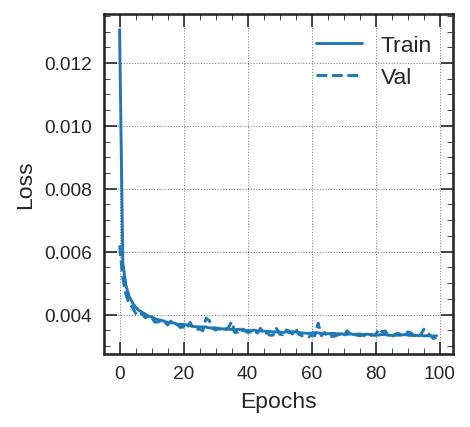

In [14]:
epochs = 100
batch_size = 2048
callbacks = None

history = ModelTrainer(model).fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

HistoryPlotter(history).plot()

### Evaluate model

In [15]:
def gaus(x,a,mu,sig):
  return a*np.exp(-0.5*np.square((x-mu)/sig))

def fit_gaus(hist, edges, mu=0., sig=1.):
  from scipy.optimize import curve_fit
  hist = hist.astype('float64')
  edges = edges.astype('float64')
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist), mu, sig])
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

def mean_squared_error(y_true, y_pred):
  # K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
  return keras.losses.mean_squared_error(y_true, y_pred).numpy()

def mean_absolute_error(y_true, y_pred):
  # K.mean(math_ops.abs(y_pred - y_true), axis=-1)
  return keras.losses.mean_absolute_error(y_true, y_pred).numpy()

def median_absolute_deviation(y_true, y_pred):
  scale = 0.6744897501960817  # special.ndtri(0.75)
  return np.median(np.abs(y_pred - y_true), axis=-1) / scale

In [16]:
y_test_true = y_test.copy()
y_test_pred = model.predict(x_test, batch_size=8192)

y_test_true /= pt_regr_scale
y_test_pred /= pt_regr_scale

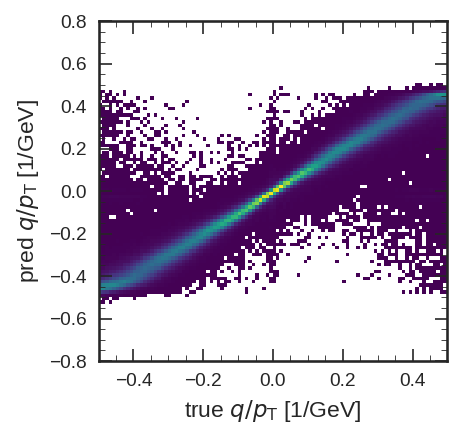

In [17]:
# Plot result
fig, ax = plt.subplots(figsize=(3,3))
xx = np.squeeze(y_test_true)
yy = np.squeeze(y_test_pred)
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
plt.show()

[INFO    ] (entries, mu, sig, mse, mae, mad): 700626, -2.6675e-03, 0.0405, 0.0033, 0.0313, 0.0464
[INFO    ] gaus fit (a, mu, sig): 46159.2, -2.6621e-03, 0.0278
[INFO    ] (entries, mu, sig, mse, mae, mad): 104723, -2.8005e-03, 0.0198, 0.0008, 0.0162, 0.0156
[INFO    ] gaus fit (a, mu, sig): 4541.4, -2.5147e-03, 0.0142


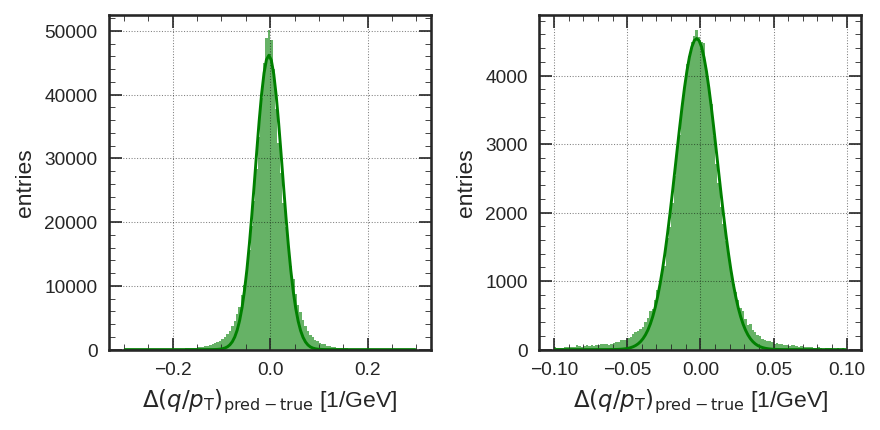

In [18]:
# Plot Delta(q/pt)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred
yy = yb - ya
yy_core = yy[np.abs(yy)<0.3]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
mu, sig, mse, mae, mad = np.mean(yy_core), np.std(yy_core), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=mu, sig=sig)
logger.info('(entries, mu, sig, mse, mae, mad): {0:d}, {1:.4e}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(len(yy), mu, sig, mse, mae, mad))
logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')

# Repeat with pt > 14 GeV
sel = (np.abs(1.0/y_test_true) > 14)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy)<0.3/3]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
mu, sig, mse, mae, mad = np.mean(yy_core), np.std(yy_core), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=mu, sig=sig)
logger.info('(entries, mu, sig, mse, mae, mad): {0:d}, {1:.4e}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(len(yy), mu, sig, mse, mae, mad))
logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')

plt.show()

[INFO    ] (entries, mu, sig, mse, mae, mad): 700626, 1.8744e-02, 0.2458, 16968962.0000, 6.0669, 8.9947
[INFO    ] gaus fit (a, mu, sig): 44573.0, 2.2351e-03, 0.1379
[INFO    ] (entries, mu, sig, mse, mae, mad): 104723, -6.5671e-02, 0.4514, 113525176.0000, 37.4869, 0.4361
[INFO    ] gaus fit (a, mu, sig): 2694.1, -1.3635e-01, 0.3246


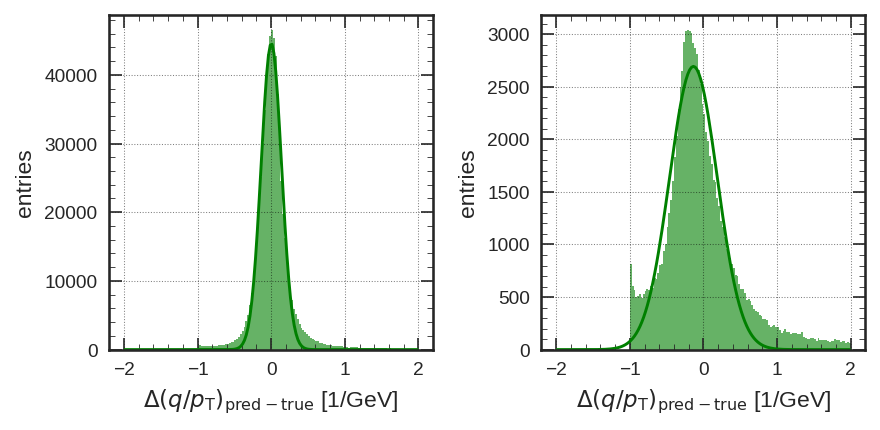

In [19]:
# Plot Delta(q/pt) / pt
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred)
yy = yb - ya
yy_core = yy[np.abs(yy)<1.5]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
mu, sig, mse, mae, mad = np.mean(yy_core), np.std(yy_core), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=mu, sig=sig)
logger.info('(entries, mu, sig, mse, mae, mad): {0:d}, {1:.4e}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(len(yy), mu, sig, mse, mae, mad))
logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > 14)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy)<1.5]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
mu, sig, mse, mae, mad = np.mean(yy_core), np.std(yy_core), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=mu, sig=sig)
logger.info('(entries, mu, sig, mse, mae, mad): {0:d}, {1:.4e}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(len(yy), mu, sig, mse, mae, mad))
logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')

plt.show()

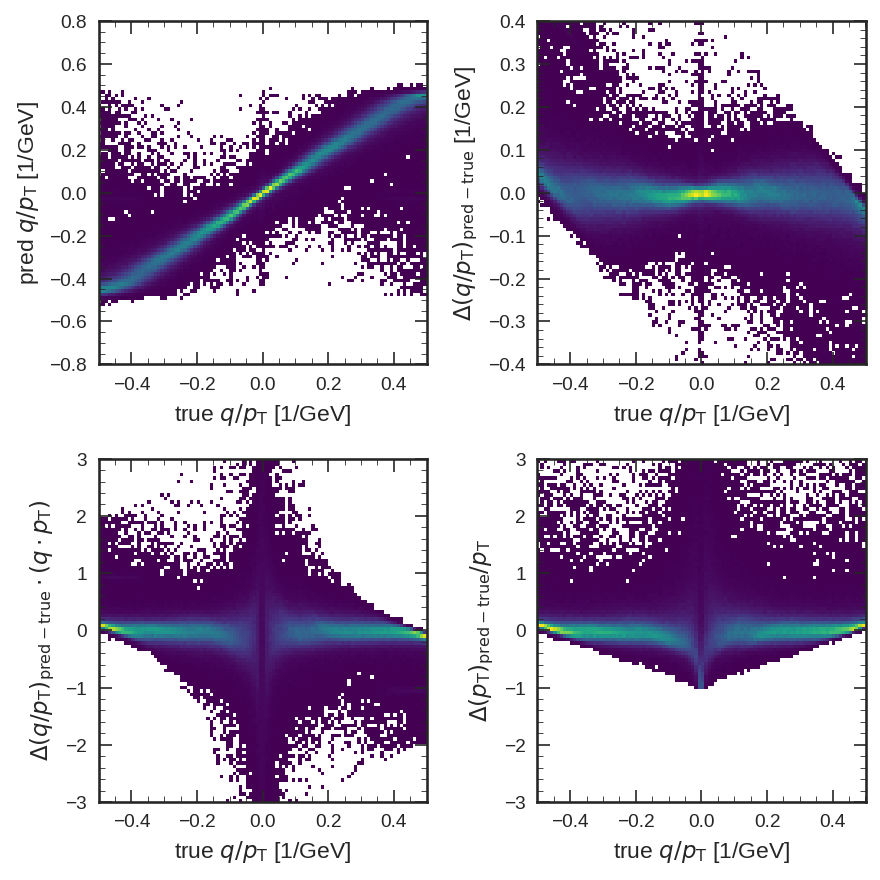

In [20]:
# Plot correlations
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred
ax = axs[0,0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')

yy = y_test_pred - y_test_true
ax = axs[0,1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')

yy = (y_test_pred - y_test_true)/np.abs(y_test_true)
ax = axs[1,0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}} \cdot (q \cdot p_{\mathrm{T}})$')

yy = np.abs(y_test_true/y_test_pred) - 1
ax = axs[1,1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')

plt.show()

In [21]:
# Make better resolution plot
# resolution defined as Delta(pt) over pt (no charge), binned in 1/pt (also no charge)
xx = np.abs(y_test_true)
yy = np.abs(y_test_true/y_test_pred) - 1
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
uuu = np.zeros(nbinsx, dtype=np.float32)

for i in range(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue

  pt = np.mean(xx_i)
  pt = 1.0/pt

  yy_i = yy[inds==i]
  yy_i = yy_i[(-1.0 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1.0)
  assert(np.abs(sig) < 2.0)

  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  try:
    popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  #print(i, len(xx_i), mu, sig, pt, popt)

  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print(i, len(xx_i), zdata.sum(), hightail)

  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]

  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  elif 28. < pt < 33.:
    ind_30GeV, xx_30GeV, yy_30GeV = i, xx_i, yy_i

  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage
  uuu[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): 307.3, -8.8954e-02, 0.2127
[INFO    ] gaus fit (a, mu, sig): 252.7, -1.0019e-01, 0.2516


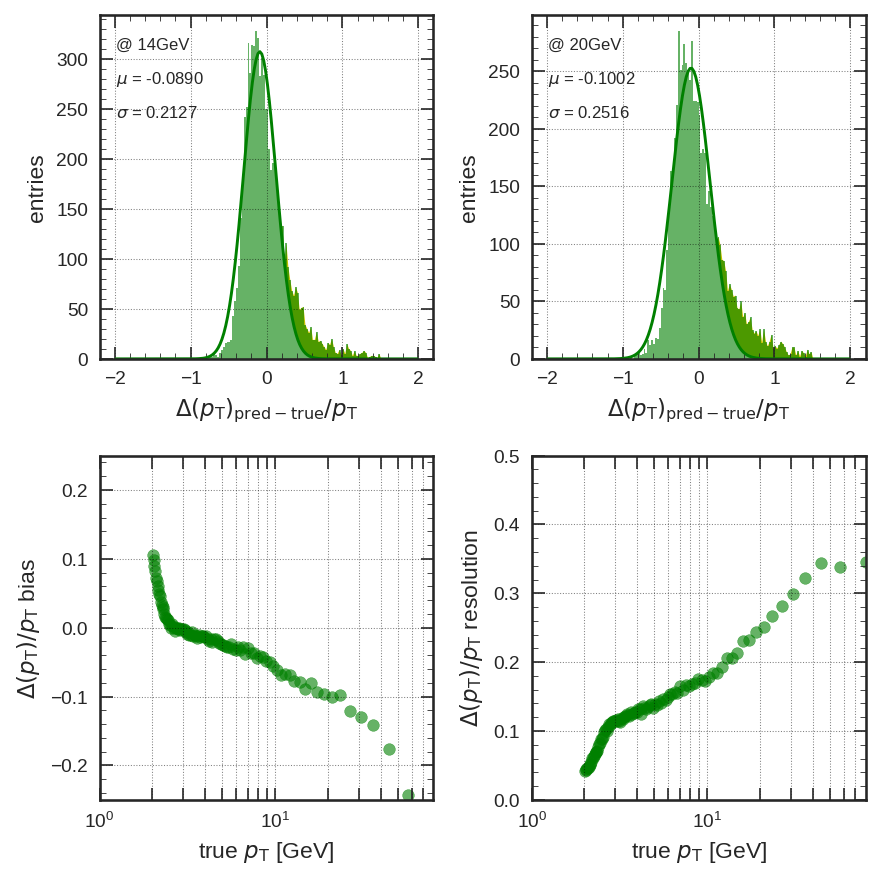

In [22]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  try:
    popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  logger.info('gaus fit (a, mu, sig): {0:.1f}, {1:.4e}, {2:.4f}'.format(popt[0], popt[1], popt[2]))

  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail

  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
ax.scatter(xxx, uuu, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))

plt.show()

[INFO    ] high tail prob: 0.1126, 0.1256, 0.1348
[INFO    ] coverage # of sigmas: 1.4091, 1.3961, 1.4170


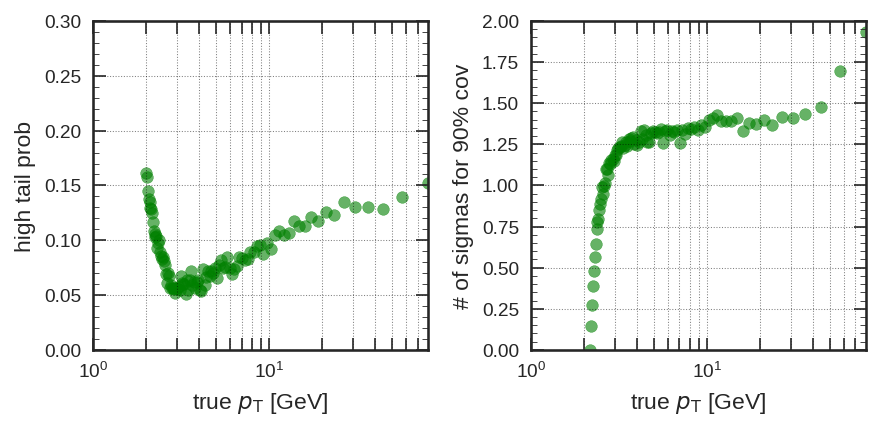

In [23]:
# Misc plots
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:.4f}, {1:.4f}, {2:.4f}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

ax = axs[0]
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail prob')
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))

# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
#print(scipy.special.erfinv(0.80) * np.sqrt(2))
logger.info('coverage # of sigmas: {0:.4f}, {1:.4f}, {2:.4f}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

ax = axs[1]
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'# of sigmas for 90% cov')
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))

plt.show()

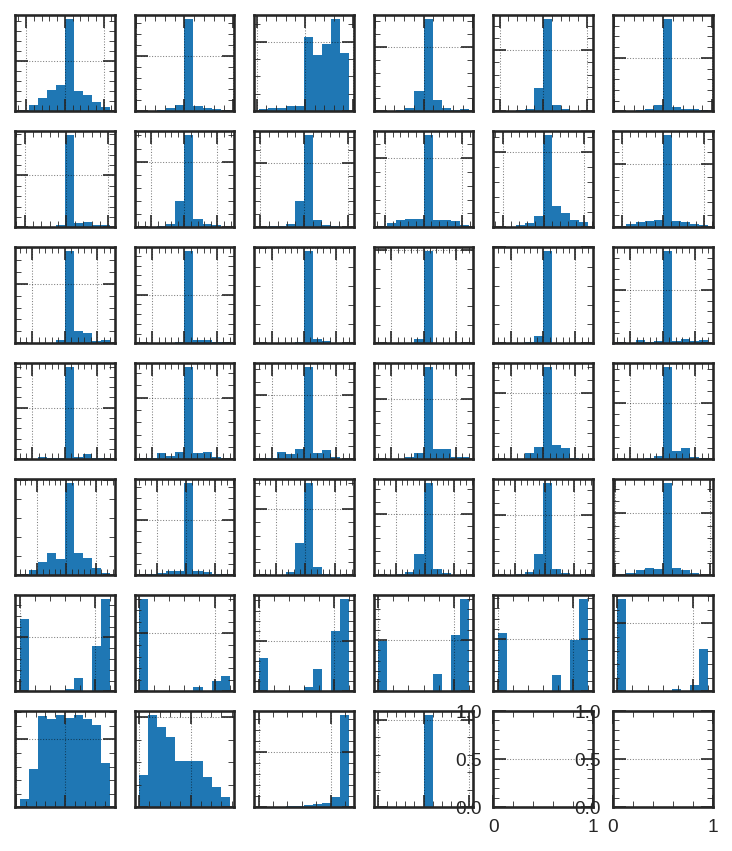

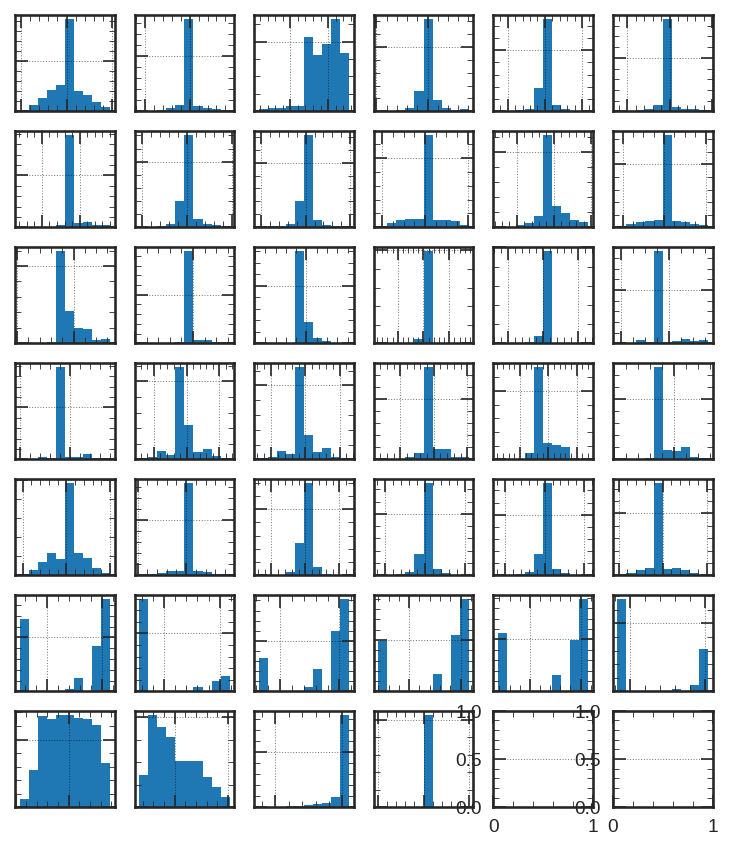

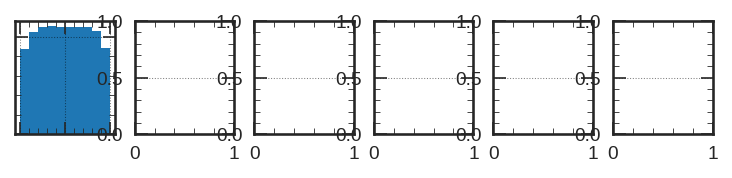

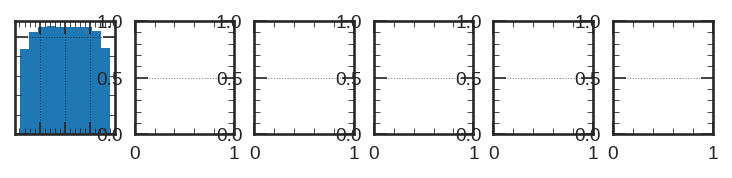

In [24]:
# Check x_train, x_train_normed, y_train, y_train_normed

x_train_normed = preprocessing_layer(x_train).numpy()
y_train_normed = y_preprocessing_layer(y_train).numpy()

def doit():
  fig, axs = plt.subplots(ni, nj, figsize=(6,6*ni/nj))
  for i in range(ni):
    for j in range(nj):
      ij = (i * nj) + j
      if ij >= nij:
        break
      #
      if axs.ndim == 2:
        ax = axs[i, j]
      elif axs.ndim == 1:
        ax = axs[j]
      else:
        ax = axs
      ax.hist(axdata[:, ij])
      ax.set_xticklabels([])
      ax.set_yticklabels([])
  #
  plt.show()

ni, nj = 7, 6
nij = 40
axdata = x_train
doit()

axdata = x_train_normed
doit()

ni, nj = 1, 6
nij = 1
axdata = y_train
doit()

axdata = y_train_normed
doit()